In [1]:
# 绘制地震活动性分布图
import pygmt 
import pandas as pd 
import geopandas as gpd
from shapely.geometry import LineString,box

import numpy as np
import xarray as xr
import os
from obspy import UTCDateTime,geodetics
import warnings
warnings.filterwarnings("ignore")
import glob
import sdc

In [2]:
from plot_utils import read_qml,plot_profile_location
from plot_utils import project_data,plot_elevation,plot_profile_value,plot_meca

In [3]:
# read the data
# read the catalog
names = ['evtid','latitude','longitude','depth','X','Y','Z','ex','ey','ez',
         'year','month','day','hour','minute','second','magnitude',
         'nccp','nccs','nctp','ncts','rcc','rct','cid']
catalog = pd.read_csv('TGR_data/tomoDD09/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)
#catalog = pd.read_csv('TGR_data/tomoDD-SE/TGR_2009/1_19/RealDataInversion/Output_Files/tomoDD.reloc',sep='\s+',names=names)

# read the station
stations = pd.read_csv('TGR_data/tomoDD09/ph2dt/station.dat',sep='\s+',names=['name','latitude','longitude','elevation'])

# read the cities
cities = pd.read_csv('TGR_data/geology/SX_citylonlat.txt',sep='\s+',encoding='gbk')
# read the gCAp
names=['x','y','longitude','latitude','depth','strike1','dip1','rake1','strike2','dip2','rake2',
       'magnitude','exp','plot_longitude','plot_latitude','name','label','time']
cap = pd.read_csv('TGR_data/gCAP/SanxiagCAP.gcmt',sep='\s+',skiprows=8,names=names)

TGR = gpd.read_file('TGR_data/geology/TGR.shp')

In [4]:
t1 = UTCDateTime('2009/3/1')
t2 = UTCDateTime('2010/12/17')
for i in range(len(catalog)):
    line  = catalog.iloc[i]
    time = UTCDateTime(int(line.year),int(line.month),int(line.day),int(line.hour),int(line.minute),0)+line.second
    catalog.loc[line.name,'time'] =  time
    catalog.loc[line.name,'reltime'] = (time-t1)/(1*24*60*60)

In [5]:
# read qml
file = 'TGR_data\\geology\\H49E006010.qml'
file = 'TGR_data\\geology\\geochron_system.qml'
file = 'TGR_data\\geology\\geochron_series.qml'
geo_categories,geo_strata = read_qml(qmlfile=file)

file = 'TGR_data\\geology\\H49E006010.gpkg'
H4909 = gpd.read_file(file, layer='strata').set_crs('EPSG:4326')
faults = gpd.read_file(file, layer='faults').set_crs('EPSG:4326')
strike_and_dip = gpd.read_file(file, layer='strike_and_dip').set_crs('EPSG:4326')

geology = H4909[['geometry','name','label','system','stages','series']].copy()
# 清洗数据
geo = geology.copy()
for i in range(len(geology)):
    data = geology.iloc[i]
    if data.geometry.is_empty:
        geo = geo.drop(index=i)
fault = faults.copy()
for i in range(len(faults)):
    data = faults.iloc[i]
    if data.geometry.is_empty:
        fault = fault.drop(index=i)
keys = ['_'.join(a.split(' ')) for a in geo['series'].values]
geo['name'] = keys

In [6]:
topo = pygmt.datasets.load_earth_relief(resolution='01s',region=[110,111,30+40/60,31+20/60])

In [7]:
model = xr.open_dataset('TGR_data/tomoDD09/TGR_2009_velocity_1_19.h5')
model = model.where(model.depth <= 8,drop=True)

# N1N2
lat_N1,lon_N1 = sdc.redist(xkm=-7,ykm=2,olat=31.0,olon=110.5,rota=0)
lat_N2,lon_N2 = sdc.redist(xkm=10,ykm=2,olat=31.0,olon=110.5,rota=0)
P_N = [lon_N1,lat_N1,lon_N2,lat_N2]

# M1M2
lat_M1,lon_M1 = sdc.redist(xkm=2,ykm=6,olat=31.0,olon=110.5,rota=0)
lat_M2,lon_M2 = sdc.redist(xkm=2,ykm=0,olat=31.0,olon=110.5,rota=0)
P_M = [lon_M1,lat_M1,lon_M2,lat_M2]

In [8]:
p = strike_and_dip.iloc[0]
data = []
for i in range(len(strike_and_dip)):
    p = strike_and_dip.iloc[i]
    strike,dip = p.strike,p.dip
    lon,lat = list(p.geometry.centroid.coords)[0]
    data.append([lon,lat,strike,dip])
strikes_df = pd.DataFrame(data,columns=['longitude','latitude','strike','dip'])

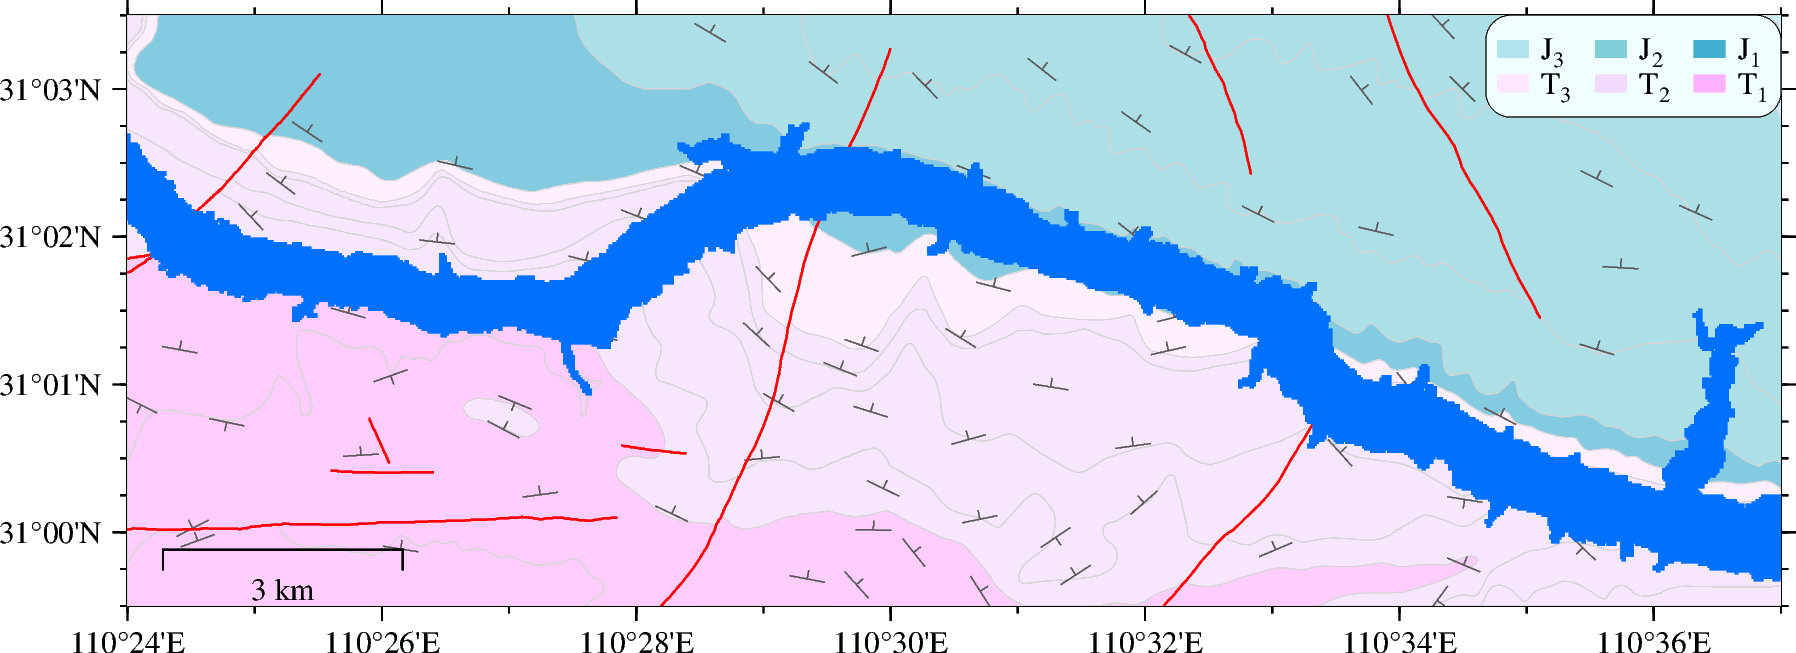

In [9]:
# Xietan geological mapview
region = [110+24/60,110+37/60,30+59.5/60,31+3.5/60]
lon1,lon2,lat1,lat2 = region 
bbox = box(min(lon1, lon2), min(lat1, lat2), max(lon1, lon2), max(lat1, lat2))
clipped_geo = geo.clip(bbox)

fig = pygmt.Figure()
pygmt.config(FONT='7.5p,4',MAP_FRAME_TYPE='plain',MAP_FRAME_PEN='0.5p')
fig.basemap(region=region,projection='M14c',frame=['xaf','yaf','WSen'])
with pygmt.clib.Session() as session:
    with pygmt.helpers.GMTTempFile() as tmpfile:
        session.call_module("mapproject", f"-Wh ->{tmpfile.name}")
        map_height = tmpfile.read().strip()
map_height = float(map_height)

# plot the stratum
idx = 0
for i,name in enumerate(list(geo_strata)):
    array = clipped_geo[clipped_geo.name == name]
    color = geo_strata[name]['color']
    label = geo_strata[name]['label']
    if len(array) <= 0:continue
    if idx == 0:label = label+'+N3'
    idx = idx+1
    fig.plot(data=array,fill=color,label=label)
    fig.plot(data=array,pen='0.1p,gray')
fig.plot(data=strikes_df,style='kgeo-plane_gentle/0.3c')
fig.plot(x=[lon1,lon1,lon2,lon2,lon1],y=[lat1,lat2,lat2,lat1,lat1],fill='white@65')
fig.legend(position='jTR+w2.5c+o0.0c/0.0c',box='+gazure1+p0.1p+r')

# plot the faults and map_scale
fig.plot(data=fault,pen='0.5p,red')
fig.basemap(map_scale='jBL+c110.5/31+w3k+l+o0.3c/0.3c')

# plot the rivers
#fig.plot(data='TGR_data/geology/Rivers.gmt',pen='0.5p,0/112/255',close=False) # Yangtze river
fig.plot(data='TGR_data/geology/TGR.shp',pen='0.5p,0/112/255',fill='0/112/255',close=False)
fig.show()

In [10]:
pygmt.makecpt(cmap='seis',series=[4.5,6.5,0.1],continuous=True,background=True,output='velp.cpt')
pygmt.makecpt(cmap='roma',series=[2.8,3.6,0.1],continuous=True,background=True,output='vels.cpt')
pygmt.makecpt(cmap='polar',series=[1.6,2.0,0.1],continuous=True,background=True,reverse=False,output='vpvs.cpt')

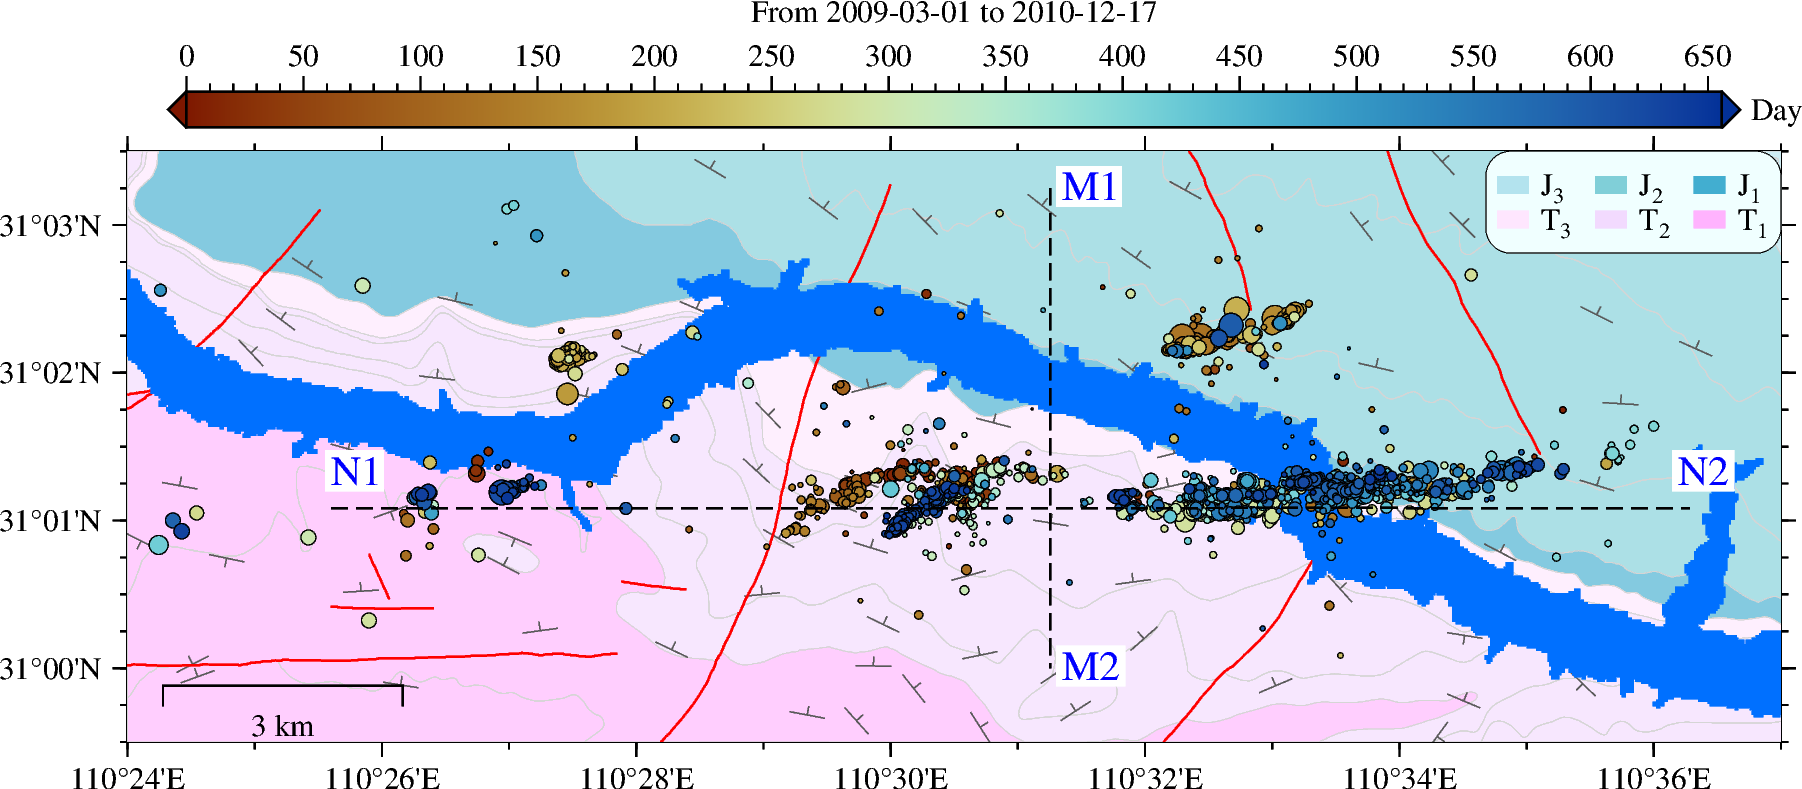

In [11]:
# plot the earthquake catalog
pygmt.makecpt(cmap='roma',series=[0,catalog.reltime.max(),1],continuous=True,output='time.cpt')
fig.plot(x=catalog.longitude,y=catalog.latitude,style='cc',size=0.06*(catalog.magnitude+1),fill=catalog.reltime,cmap='time.cpt',pen='0.2p')

fig.colorbar(position='jTC+w13c/0.3c+o0.0c/-0.5c+m+e+h',frame=['xa50f10+lFrom 2009-03-01 to 2010-12-17','y+lDay'],cmap='time.cpt')

# plot the profile location
length_N = plot_profile_location(fig,P_N,label=['N1','N2'],offset=['0.0c/0.2c','-0.1c/0.2c'])
length_M = plot_profile_location(fig,P_M,label=['M1','M2'],offset=['0.1c/-0.1c','0.1c/-0.1c'])

# plot grids
grid_x,grid_y,grid_z = model.longitude.values,model.latitude.values,model.depth.values
grid_xy = np.meshgrid(grid_x,grid_y)
grid_xz = np.meshgrid(grid_x,grid_z)
grid_zy = np.meshgrid(grid_z,grid_y)
#fig.plot(x=grid_xy[0].flatten(),y=grid_xy[1].flatten(),style='+0.02i',pen='0.2p,red')
# label grid
for lon in grid_x:
    lat = grid_y[grid_y.searchsorted(region[2])]
    xkm,ykm = sdc.dist(xlat=lat,xlon=lon,olat=31.0,olon=110.5,rota=0)
    #fig.text(x=lon,y=lat,text=round(xkm),font='6p,4,blue',justify='TC',offset='0c/-0.1c')
for lat in grid_y:
    lon = grid_x[grid_x.searchsorted(region[0])]
    xkm,ykm = sdc.dist(xlat=lat,xlon=lon,olat=31.0,olon=110.5,rota=0)
    #fig.text(x=lon,y=lat,text=round(ykm),font='6p,4,blue',justify='ML',offset='0.1c/0c')
fig.show()

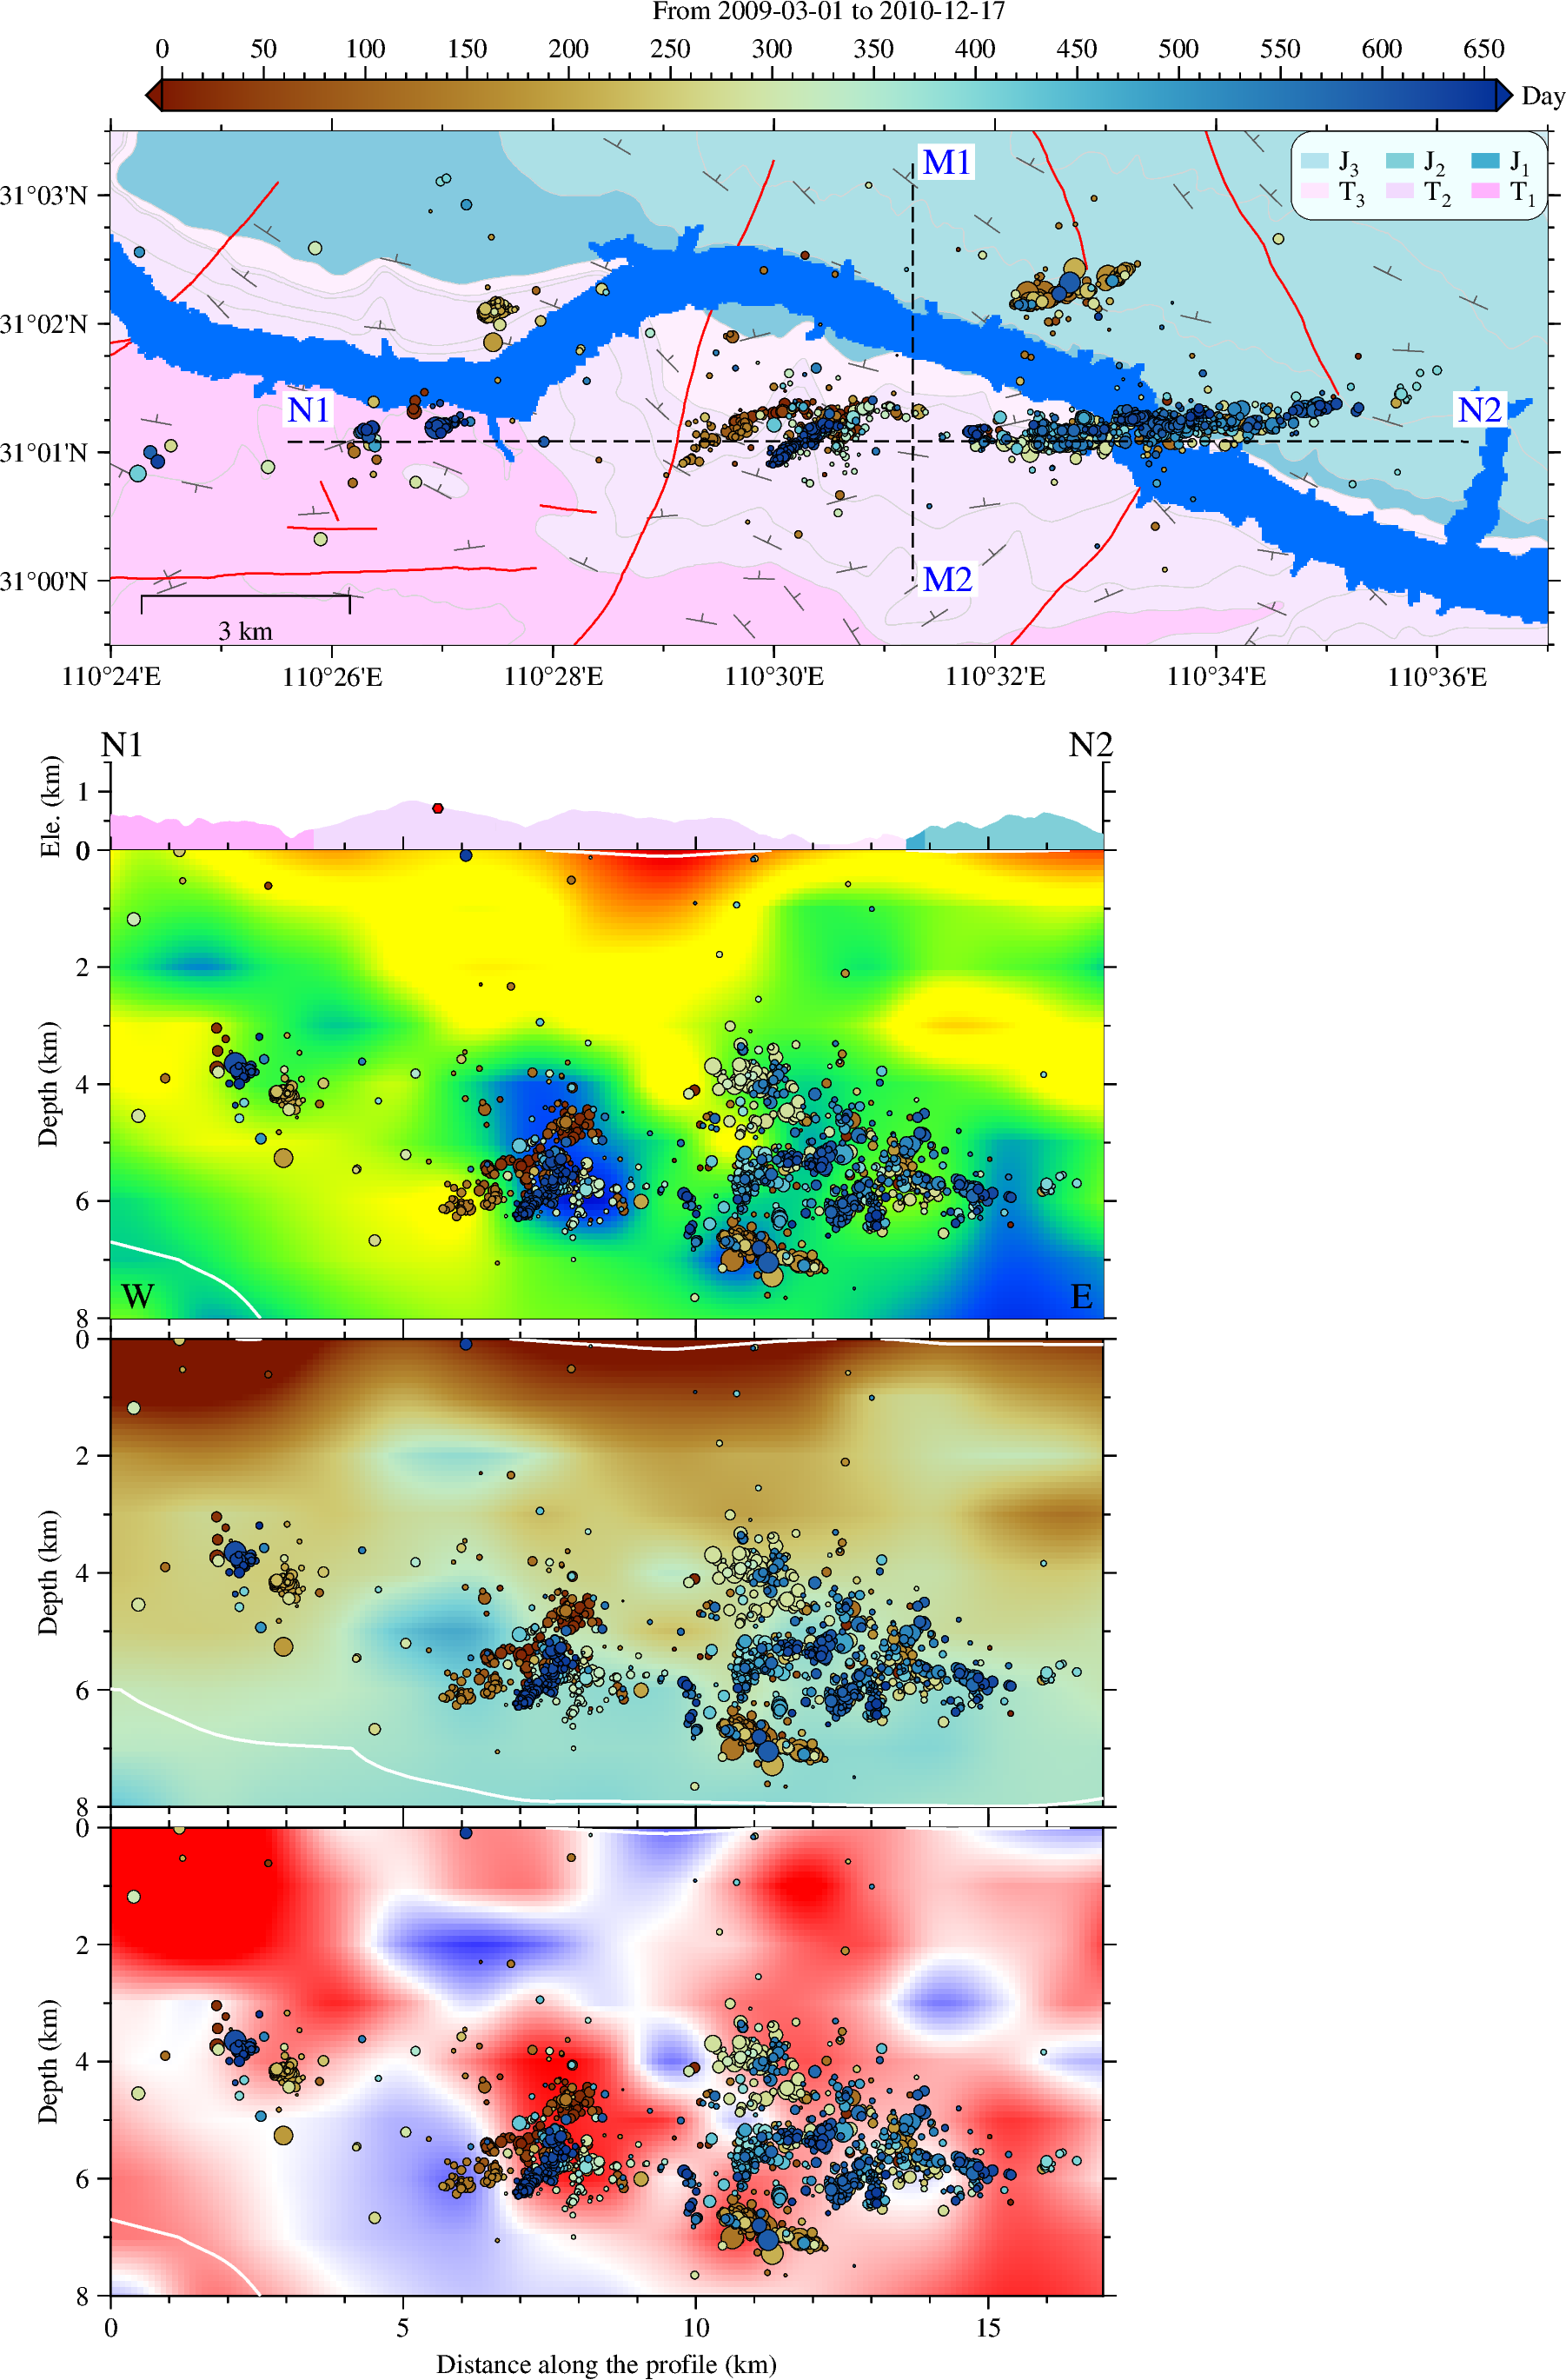

In [12]:
# plot H1H2
lon1,lat1,lon2,lat2 = P_N
track = pygmt.project(data=None,center=[lon1,lat1],endpoint=[lon2,lat2],generate=0.01,unit=True)
length = track.p.max()

lon1,lat1,lon2,lat2 = P_M
track = pygmt.project(data=None,center=[lon1,lat1],endpoint=[lon2,lat2],generate=0.01,unit=True)
length2 = track.p.max()

width = 5
xscale = (14-0.9)/(length+length2)
zscale = xscale*1.0
scale = xscale
reloc,meca = project_data(catalog,cap,P_N,width=5)

fig.shift_origin(yshift='-2.0c')
fig.basemap(region=[0,length,0,1.5],projection='x{}c/{}c'.format(xscale,zscale),frame=['xaf','ya1f0.5+lEle. (km)','We'])
fig.text(position='cTL',offset='-0.1c/0.3c',text='N1',font='10p',no_clip=True)
fig.text(position='cTR',offset='+0.1c/0.3c',text='N2',font='10p',no_clip=True)
plot_elevation(fig,topo,TGR,geo_strata,fault,geo,P_N)

fig.shift_origin(yshift='-{}c'.format(8*zscale+0.0))
fig.basemap(region=[0,length,0,8],projection='x{}c/-{}c'.format(xscale,zscale),frame=['xaf+lDistance along the profile (km)','yaf+lDepth (km)','Wsen'])
plot_profile_value(fig,model,topo,catalog,meca,P_N,zscale,label=['W','E'],width=width,colorbar=False,interval=20)
fig.show()

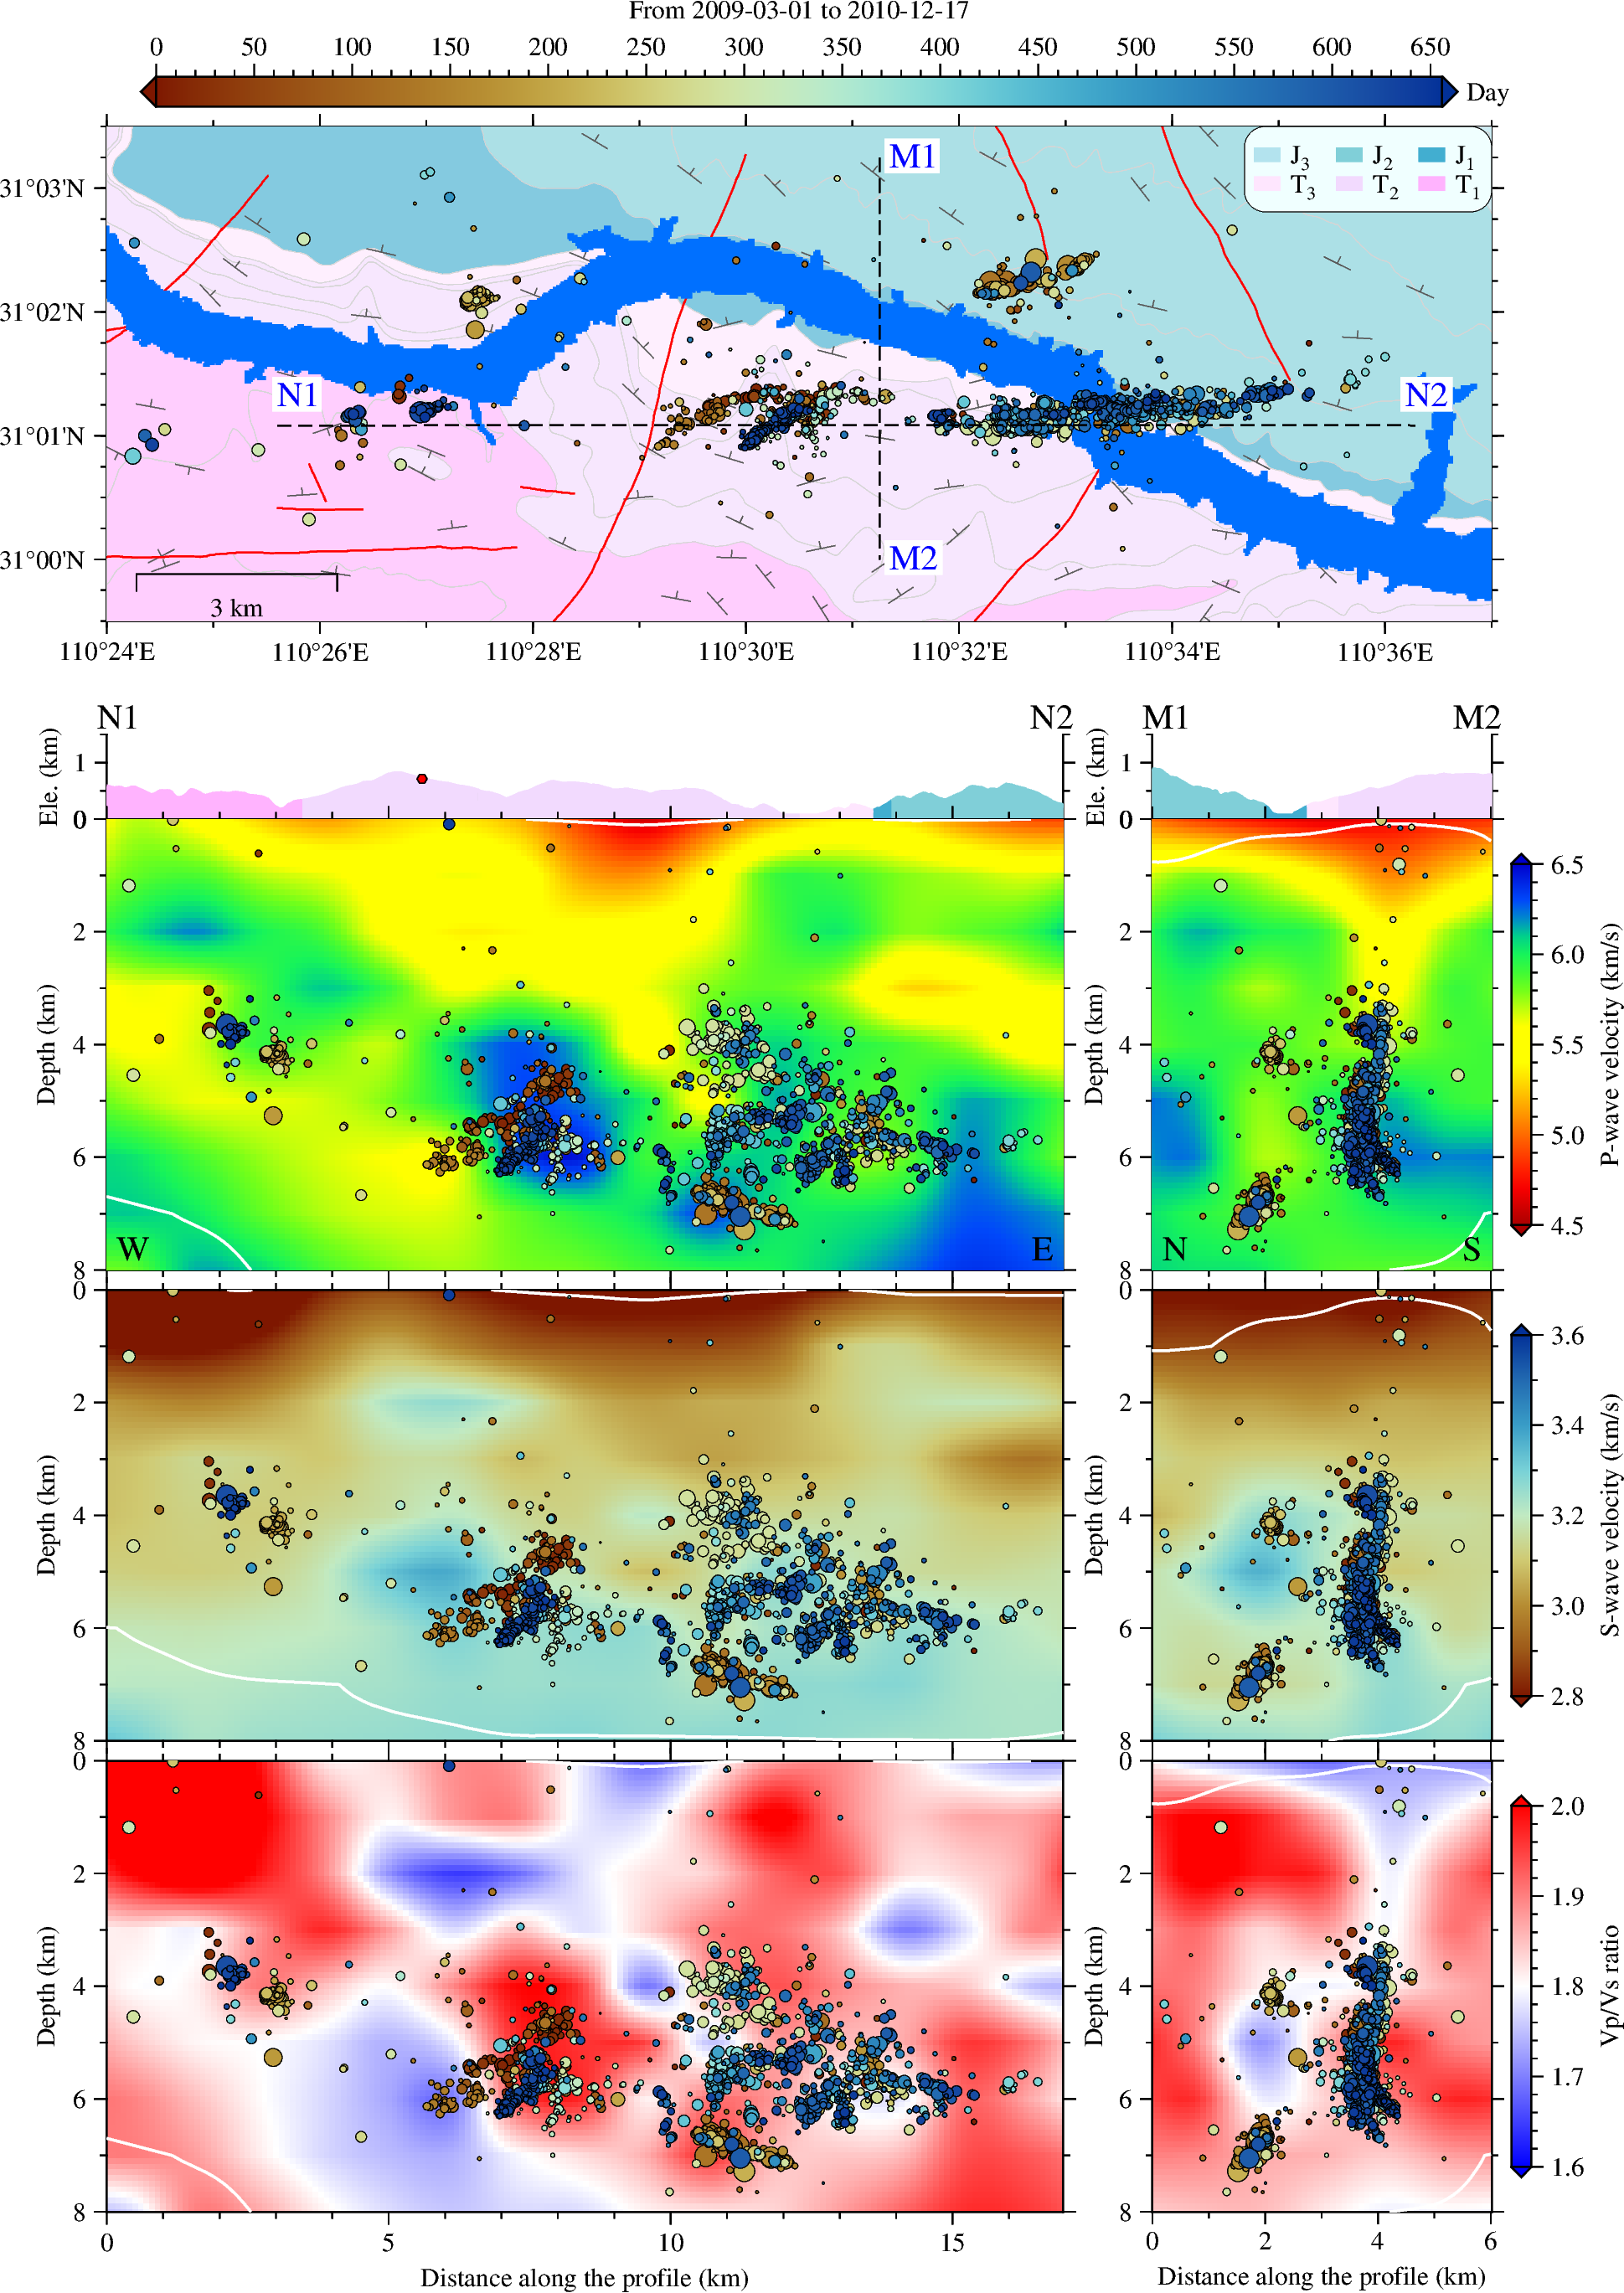

In [13]:
fig.shift_origin(xshift='{}c'.format(length*xscale+0.9),yshift='{}c'.format((8*zscale+0.2)*3-0.2))

lon1,lat1,lon2,lat2 = P_M
track = pygmt.project(data=None,center=[lon1,lat1],endpoint=[lon2,lat2],generate=0.01,unit=True)
length = track.p.max()
width = 10
reloc,meca = project_data(catalog,cap,P_M,width=5)

fig.basemap(region=[0,length,0,1.5],projection='x{}c/{}c'.format(xscale,zscale),frame=['xaf','ya1f0.5+lEle. (km)','We'])
fig.text(position='cTL',offset='-0.1c/0.3c',text='M1',font='10p',no_clip=True)
fig.text(position='cTR',offset='+0.1c/0.3c',text='M2',font='10p',no_clip=True)
plot_elevation(fig,topo,TGR,geo_strata,fault,geo,P_M)
fig.shift_origin(yshift='-{}c'.format(8*zscale+0.0))
fig.basemap(region=[0,length,0,8],projection='x{}c/-{}c'.format(xscale,zscale),frame=['xaf+lDistance along the profile (km)','yaf+lDepth (km)','Wsen'])
plot_profile_value(fig,model,topo,catalog,meca,P_M,zscale,label=['N','S'],width=width,colorbar=True,interval=20)
fig.show()

In [14]:
fig.savefig('plotting_figures'+os.sep+'Figure15_Xietan.png',dpi=600)
fig.savefig('plotting_figures'+os.sep+'Figure15_Xietan.pdf')

In [15]:
for file in glob.glob('*.cpt'):
    os.remove(file)